In [47]:
import pandas as pd
from server_config import ENGINE_LINK
from sqlalchemy import create_engine

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

plt.style.use('fivethirtyeight')

In [2]:
tvs = pd.read_csv('data/tvs_bd.csv')
tvs.tail(3)

,show_id,total_duration,kp_rating,imdb_rating,genres,clean_description,vectorizer
69502,Убийство первой степени_2014_series,22.933333,6.595,7.2,"Криминал,Драма,Детектив",центр сюжет сериал действие который разворачив...,"(0, 1655193)\t0.1693229607495187\n (0, 1464..."
69503,Борджиа_2011_series,36.100000,7.863,7.8,"Приключения,Драма,Исторический",шокир путь восхождение власть доминирование са...,"(0, 944170)\t0.12858310246141283\n (0, 3914..."
69504,Самый лучший хит_2017_series,16.000000,7.781,7.6,"Драма,Музыкальный,Романтика",юный дже юный юный музыкальный гений участник ...,"(0, 613041)\t0.09828099894710936\n (0, 8743..."


In [3]:
df = pd.read_excel('./data/films_data.xlsx').loc[:, 'user_id':].rename(columns={'genres' : 'genre'})
df = df.loc[(df['release_year'].isna() == False) & (df['title'].isna() == False) & (df['content_type'].isna() == False)].reset_index(drop=True)
df['show_id'] = df['title'] + '_' + df['release_year'].apply(int).apply(str) + '_' + df['content_type']
df = pd.merge(df, tvs, how='inner', on='show_id')

In [4]:
df['hours_watched'] = round(df['total_duration'] * df['watched_pct'] / 100, 2)
df

,user_id,item_id,last_watch_dt,total_dur,watched_pct,age,income,sex,kids_flg,content_type,...,for_kids,age_rating,show_id,total_duration,kp_rating,imdb_rating,genres,clean_description,vectorizer,hours_watched
0,964868,9506,2021-04-30,6725,100.0,age_25_34,income_20_40,Ж,0,film,...,NaN,0,Холодное сердце_2013_film,1.700000,7.840,7.4,"Мультфильмы,Семейный,Приключения,Фэнтези",древний предсказание сбываться королевство пог...,"(0, 580193)\t0.11329260659009611\n (0, 1403...",1.70
1,717123,9506,2021-05-08,22443,100.0,age_35_44,income_60_90,М,1,film,...,NaN,0,Холодное сердце_2013_film,1.700000,7.840,7.4,"Мультфильмы,Семейный,Приключения,Фэнтези",древний предсказание сбываться королевство пог...,"(0, 580193)\t0.11329260659009611\n (0, 1403...",1.70
2,910745,9506,2021-08-21,5962,100.0,age_25_34,income_0_20,М,0,film,...,NaN,0,Холодное сердце_2013_film,1.700000,7.840,7.4,"Мультфильмы,Семейный,Приключения,Фэнтези",древний предсказание сбываться королевство пог...,"(0, 580193)\t0.11329260659009611\n (0, 1403...",1.70
3,706527,9506,2021-06-05,5416,92.0,age_25_34,income_20_40,Ж,0,film,...,NaN,0,Холодное сердце_2013_film,1.700000,7.840,7.4,"Мультфильмы,Семейный,Приключения,Фэнтези",древний предсказание сбываться королевство пог...,"(0, 580193)\t0.11329260659009611\n (0, 1403...",1.56
4,66128,9506,2021-06-26,5333,90.0,age_45_54,income_20_40,М,0,film,...,NaN,0,Холодное сердце_2013_film,1.700000,7.840,7.4,"Мультфильмы,Семейный,Приключения,Фэнтези",древний предсказание сбываться королевство пог...,"(0, 580193)\t0.11329260659009611\n (0, 1403...",1.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67407,1041965,228,2021-04-18,17,0.0,age_35_44,income_20_40,Ж,0,series,...,NaN,12,Женская доля_2014_series,403.333333,7.922,NaN,"Драма,Романтика,Комедия",мечта мать свой семья девочка счастливый надея...,"(0, 1268989)\t0.13198083078376893\n (0, 130...",0.00
67408,346233,356,2021-04-12,56,1.0,age_18_24,income_20_40,М,0,film,...,NaN,16,Идеальные каникулы_2015_film,1.583333,NaN,NaN,"Ужасы,Триллер,Боевик",группа незнакомый человек просыпаться остров о...,"(0, 1065331)\t0.35424272443923155\n (0, 934...",0.02
67409,401695,9831,2021-03-19,10679,100.0,age_45_54,income_20_40,Ж,0,film,...,NaN,16,Арена_2017_film,1.450000,NaN,3.9,"Боевик,Триллер",звезда мма шон диллоно решать бросить бой ради...,"(0, 32132)\t0.1411868548779273\n (0, 552092...",1.45
67410,458107,9455,2021-08-22,2710,38.0,age_35_44,income_40_60,Ж,1,film,...,NaN,18,Снеговик_2017_film,1.983333,5.730,5.1,"Криминал,Триллер,Ужасы",год основа дело который расследовать детектив ...,"(0, 438580)\t0.0972373847780565\n (0, 10406...",0.75


### RFM-Анализ

* Recency (давность) — давность сделки, чем меньше времени прошло с момента последней активности клиента, тем больше вероятность, что он повторит действие
* Frequency (частота) — количество сделок, чем больше каких-либо действий совершил клиент, тем больше вероятность того, что он его повторит в будущем
* Monetary (деньги) — сумма сделок, чем больше денег было потрачено, тем больше вероятность того, что он сделает зака

![RFM-Анализ](https://uploads-ssl.webflow.com/5a3f51b87b791a0001979d8e/60f594825543813a16a3e0a5_v1yZFTEnPoDrASugj2h7YFpKMjURRclBZdjdUkzg3yM8YUgCx4dPNLHxwZ3dNmJjgmWqVmOK88VWcFQKstQ4fjvzQQ1IC4ntMnDCySaadQd4nocKyyKaFttgP5UknckQS7KKBMS_.png)

### Recency

In [5]:
df['last_watch_dt'] = pd.to_datetime(df['last_watch_dt'])

rec = df.groupby(['user_id'])['last_watch_dt'].max().reset_index()

LAST_DATE = max(rec['last_watch_dt'])

def get_days_passed(x):
    return (LAST_DATE - x).days

rec['days_passed'] = rec['last_watch_dt'].map(get_days_passed)

In [6]:
rec['days_passed'].describe()

count    57134.000000
mean        57.227955
std         42.509655
min          0.000000
25%         22.000000
50%         50.000000
75%         83.000000
max        162.000000
Name: days_passed, dtype: float64

In [7]:
# rec['recency'] = pd.qcut(rec['days_passed'], 3, labels=False) + 1

In [8]:
def get_recency(x):
    if x <= 30:
        return 'R1'
    elif x > 30 and x <= 90:
        return 'R2'
    return 'R3'


rec['recency'] = rec['days_passed'].map(get_recency)

In [9]:
rec.groupby('recency')['days_passed'].agg(['mean', 'count'])

,mean,count
recency,,
R1,14.176779,19103
R2,57.141809,25478
R3,122.917550,12553


In [10]:
# rec['recency'] = rec['recency'].map({1 : 'R1', 2 : 'R2', 3 : 'R3'})

<AxesSubplot: title={'center': 'Recency'}, xlabel='Количество дней', ylabel='Количество пользователей'>

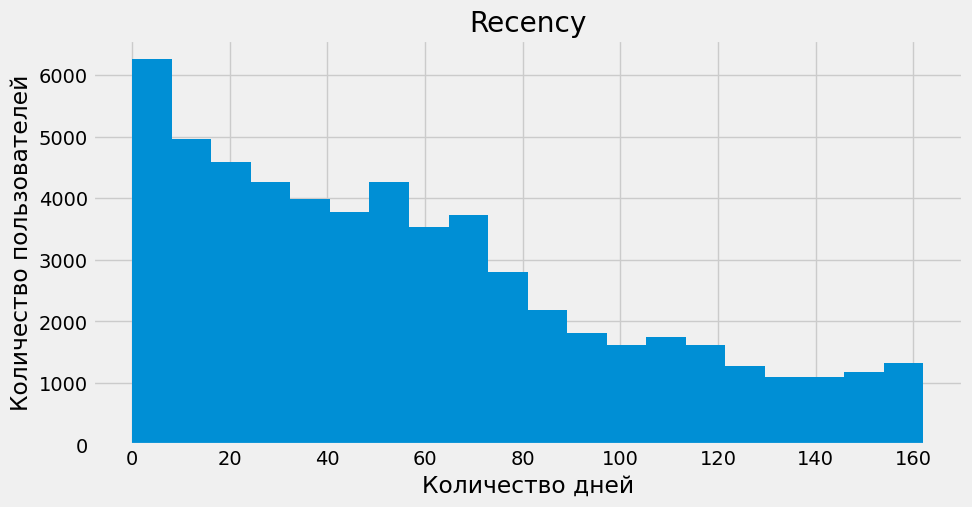

In [11]:
plt.figure(figsize=(10, 5))
plt.title('Recency')
plt.xlabel('Количество дней')
plt.ylabel('Количество пользователей')
rec['days_passed'].hist(bins=20)

### Frequency

In [12]:
freq = df.groupby(['user_id'])['hours_watched'].sum().reset_index()
freq = freq.loc[freq['hours_watched'] > 0 ].reset_index(drop=True)
freq

,user_id,hours_watched
0,2,1.53
1,25,0.24
2,46,1.70
3,55,12.24
4,126,2.07
...,...,...
50259,1097435,1.78
50260,1097444,3.04
50261,1097459,2.05
50262,1097508,0.48


In [13]:
# freq['f'] = pd.qcut(freq['hours_watched'], 3, labels=False) + 1

# freq.groupby('f')['hours_watched'].agg(['mean', 'count'])

In [14]:
freq['hours_watched'].describe(percentiles=[0.05, 0.1, 0.25, 0.4, 0.5, 0.75, 0.9, 0.95, 0.97])

count    50264.000000
mean         2.054421
std          5.114344
min          0.010000
5%           0.020000
10%          0.060000
25%          0.300000
40%          0.870000
50%          1.420000
75%          1.980000
90%          4.110000
95%          6.520000
97%          8.341100
max        266.310000
Name: hours_watched, dtype: float64

<AxesSubplot: title={'center': 'Frequency'}, xlabel='Просмотренных часов', ylabel='Количество пользователей'>

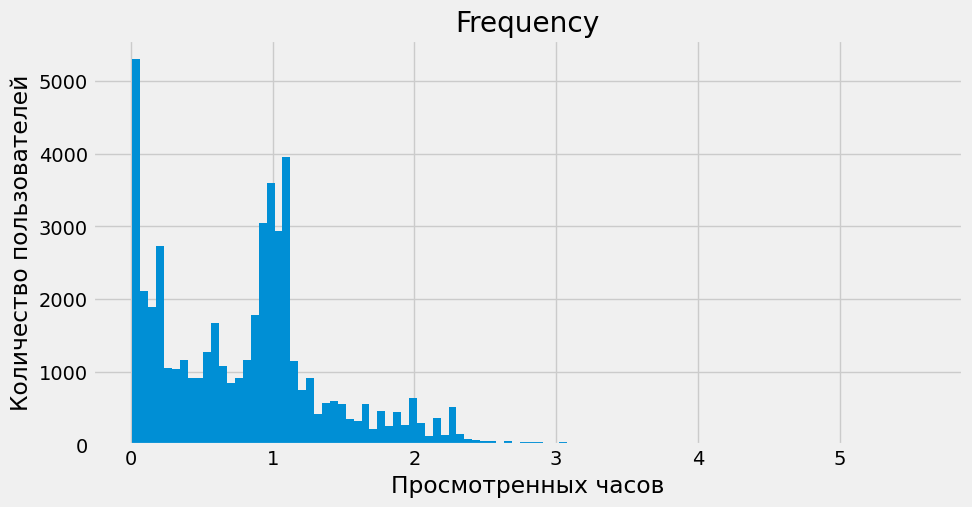

In [51]:
plt.figure(figsize=(10, 5))
plt.title('Frequency')
plt.xlabel('Просмотренных часов')
plt.ylabel('Количество пользователей')
np.log1p(freq['hours_watched']).hist(bins=100)

In [16]:
import math

se = freq['hours_watched'].std() / math.sqrt(freq.shape[0])
x_mean = freq['hours_watched'].mean()
print(f"Доверительный интервал 95%: [{x_mean - 1.96 * se}; {x_mean + 1.96 * se}]")

Доверительный интервал 95%: [2.0097101325753055; 2.099132776862861]


In [17]:
def get_frequency(x):
    if x <= 1:
        return 'F3'
    elif x > 1 and x <= 3:
        return 'F2'
    return 'F1'

freq['frequency'] = freq['hours_watched'].map(get_frequency)

In [18]:
freq.groupby('frequency')['hours_watched'].agg(['mean', 'count'])

,mean,count
frequency,,
F1,7.955232,7253
F2,1.779451,21622
F3,0.331425,21389


In [19]:
df.groupby(['user_id'])['kp_rating'].mean()

user_id
2          8.100
25         7.560
46         8.063
55         8.167
126        6.750
           ...  
1097444    6.860
1097459    7.600
1097508    8.010
1097544    7.054
1097547      NaN
Name: kp_rating, Length: 57134, dtype: float64

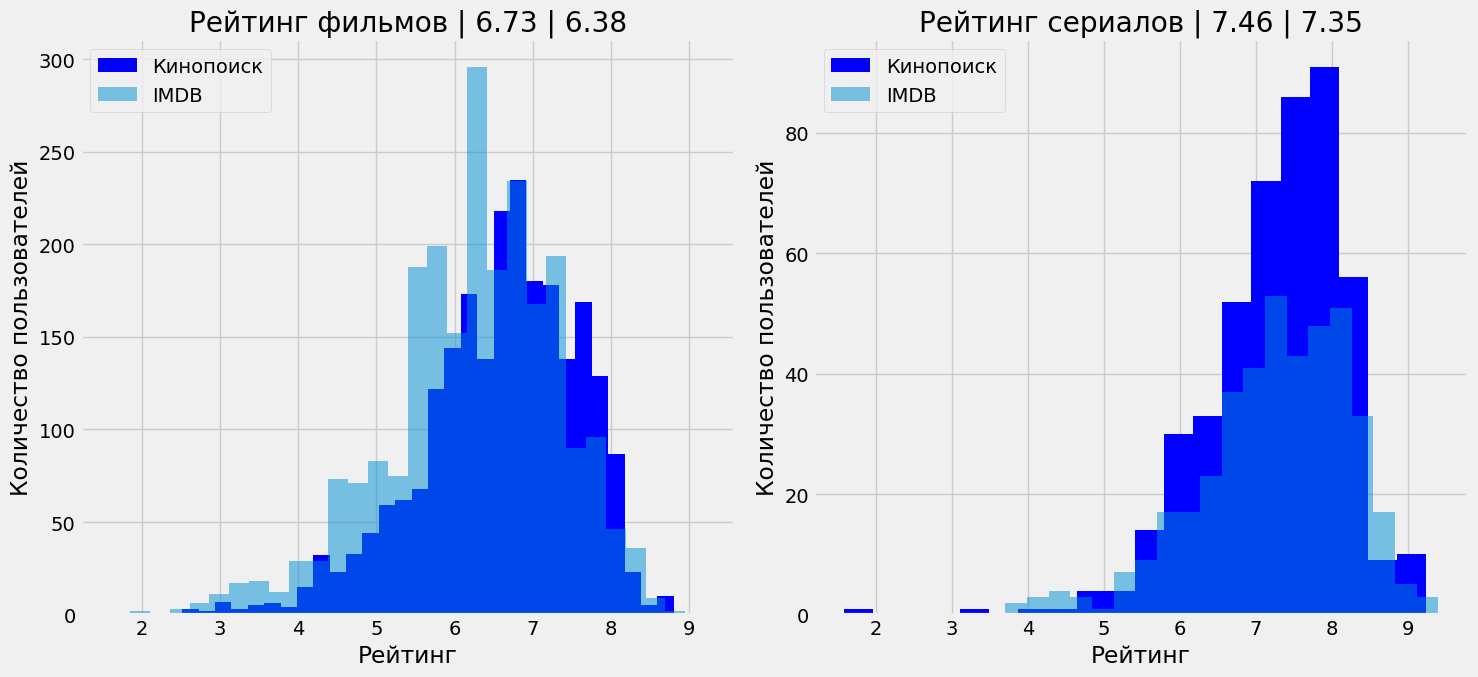

In [20]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title(f"Рейтинг фильмов | {round(df.loc[df['content_type'] == 'film', 'kp_rating'].mean(), 2)} | {round(df.loc[df['content_type'] == 'film', 'imdb_rating'].mean(), 2)}")
plt.xlabel('Рейтинг')
plt.ylabel('Количество пользователей')
plt.hist(df.loc[df['content_type'] == 'film'].groupby(['item_id'])['kp_rating'].mean(), label='Кинопоиск', bins=30, color='b')
plt.hist(df.loc[df['content_type'] == 'film'].groupby(['item_id'])['imdb_rating'].mean(), label='IMDB', bins=30, alpha=0.5)
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.title(f"Рейтинг сериалов | {round(df.loc[df['content_type'] == 'series', 'kp_rating'].mean(), 2)} | {round(df.loc[df['content_type'] == 'series', 'imdb_rating'].mean(), 2)}")
plt.xlabel('Рейтинг')
plt.ylabel('Количество пользователей')
plt.hist(df.loc[df['content_type'] == 'series'].groupby(['item_id'])['kp_rating'].mean(), label='Кинопоиск', bins=20, color='b')
plt.hist(df.loc[df['content_type'] == 'series'].groupby(['item_id'])['imdb_rating'].mean(), label='IMDB', bins=20, alpha=0.5)
plt.legend(loc='upper left')

plt.tight_layout()

100%|██████████| 46/46 [00:00<00:00, 45970.45it/s]


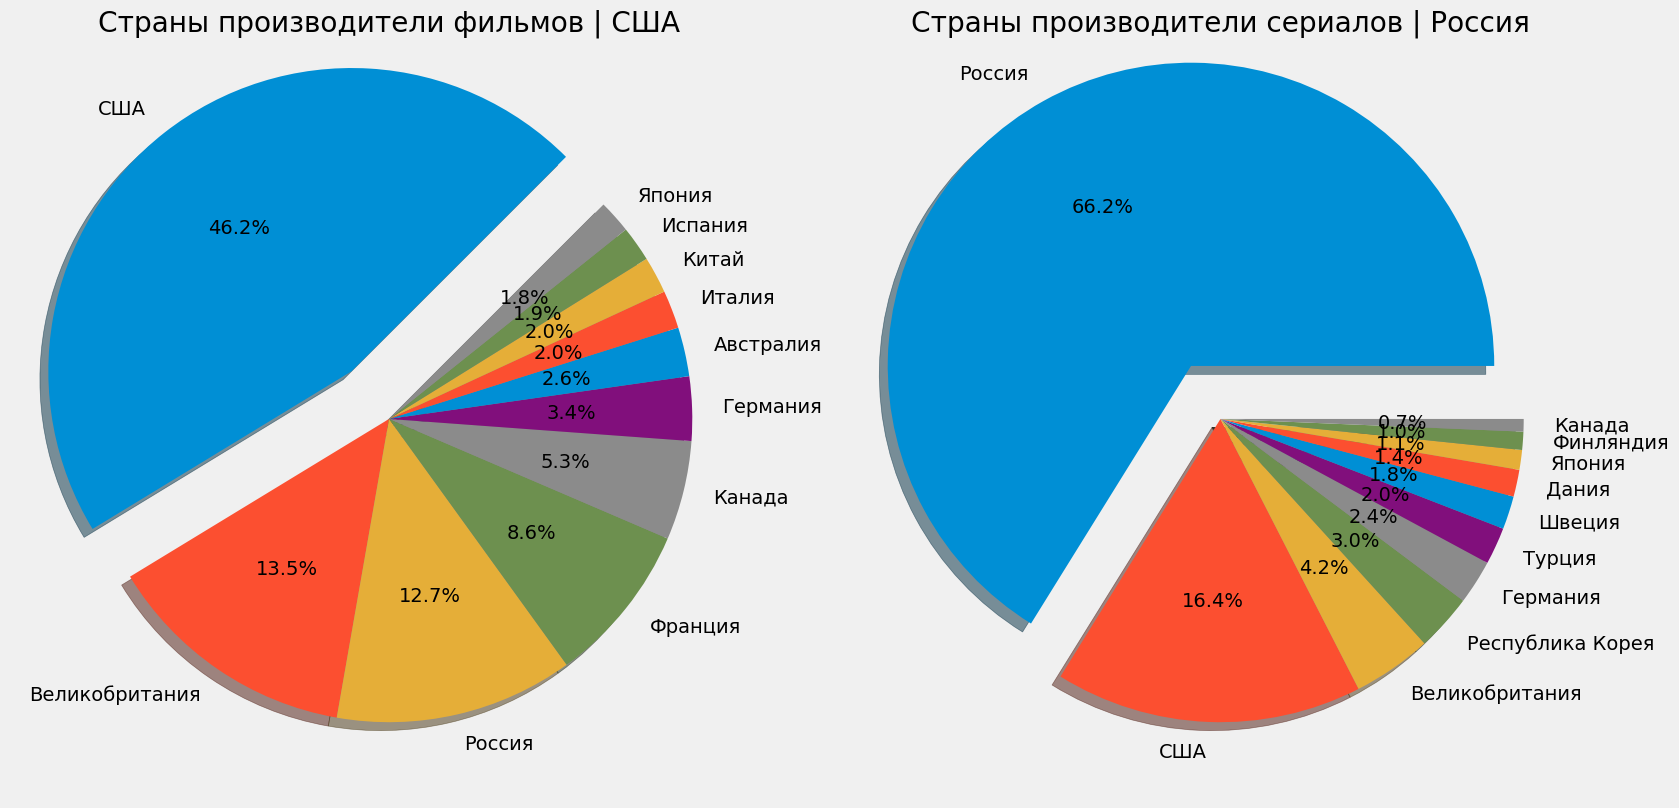

In [21]:
COUNTRIES = {}

tmp_df = df.loc[df['content_type'] == 'film'].copy()

for country_row, count in zip(tqdm(tmp_df['countries'].value_counts().index), tmp_df['countries'].value_counts()):
    countries = country_row.split(', ')
    for country in countries:
        try:
            COUNTRIES[country]
        except KeyError:
            COUNTRIES[country] = 0
        COUNTRIES[country] += count
        
countries_df = pd.DataFrame(COUNTRIES, index=range(1)).T.reset_index()
countries_df = countries_df.rename(columns={'index' : 'country', 0 : 'count'}).sort_values(by='count', ascending=False).reset_index(drop=True)
countries_df = countries_df.iloc[:11]

plt.figure(figsize=(17, 9))
plt.subplot(1, 2, 1)
plt.title(f"Страны производители фильмов | {df.loc[(df['content_type'] == 'film') & (df['countries'].isin(countries_df.country.values[:10])), 'countries'].mode()[0]}")
y = list(countries_df['count'])
labels = list(countries_df['country'])
explode = [0.2] + [0 for _ in range(countries_df.shape[0] - 1)]
plt.pie(y, labels = labels, explode = explode, shadow = True, autopct='%1.1f%%', startangle=45)
plt.tight_layout()



COUNTRIES = {}

tmp_df = df.loc[df['content_type'] == 'series'].copy()

for country_row, count in zip(tqdm(tmp_df['countries'].value_counts().index), tmp_df['countries'].value_counts()):
    countries = country_row.split(', ')
    for country in countries:
        try:
            COUNTRIES[country]
        except KeyError:
            COUNTRIES[country] = 0
        COUNTRIES[country] += count
        
countries_df = pd.DataFrame(COUNTRIES, index=range(1)).T.reset_index()
countries_df = countries_df.rename(columns={'index' : 'country', 0 : 'count'}).sort_values(by='count', ascending=False).reset_index(drop=True)
countries_df = countries_df.iloc[:11]

plt.subplot(1, 2, 2)
plt.title(f"Страны производители сериалов | {df.loc[(df['content_type'] == 'series') & (df['countries'].isin(countries_df.country.unique())), 'countries'].mode()[0]}")
y = list(countries_df['count'])
labels = list(countries_df['country'])
explode = [0.2] + [0 for _ in range(countries_df.shape[0] - 1)]
plt.pie(y, labels = labels, explode = explode, shadow = True, autopct='%1.1f%%')
plt.tight_layout()

In [41]:
GENRES = {}

tmp_df = df.loc[df['sex'] == 'Ж'].copy()

for genres_row, count in zip(tqdm(tmp_df['genres'].value_counts().index), tmp_df['genres'].value_counts()):
    genres = genres_row.split(',')
    for genre in genres:
        try:
            GENRES[genre]
        except KeyError:
            GENRES[genre] = 0
        GENRES[genre] += count
        
genres_df = pd.DataFrame(GENRES, index=range(1)).T.reset_index()
genres_df = genres_df.rename(columns={'index' : 'genre', 0 : 'count'}).sort_values(by='count', ascending=False).reset_index(drop=True)
genres_df = genres_df.iloc[:11]

100%|██████████| 889/889 [00:00<00:00, 222027.88it/s]


,genre,count
0,Драма,16839
1,Комедия,10353
2,Триллер,9408
3,Боевик,8038
4,Романтика,6320
5,Приключения,6183
6,Семейный,4351
7,Криминал,4039
8,Детектив,4017
9,Фантастика,3876


100%|██████████| 882/882 [00:00<00:00, 293717.83it/s]


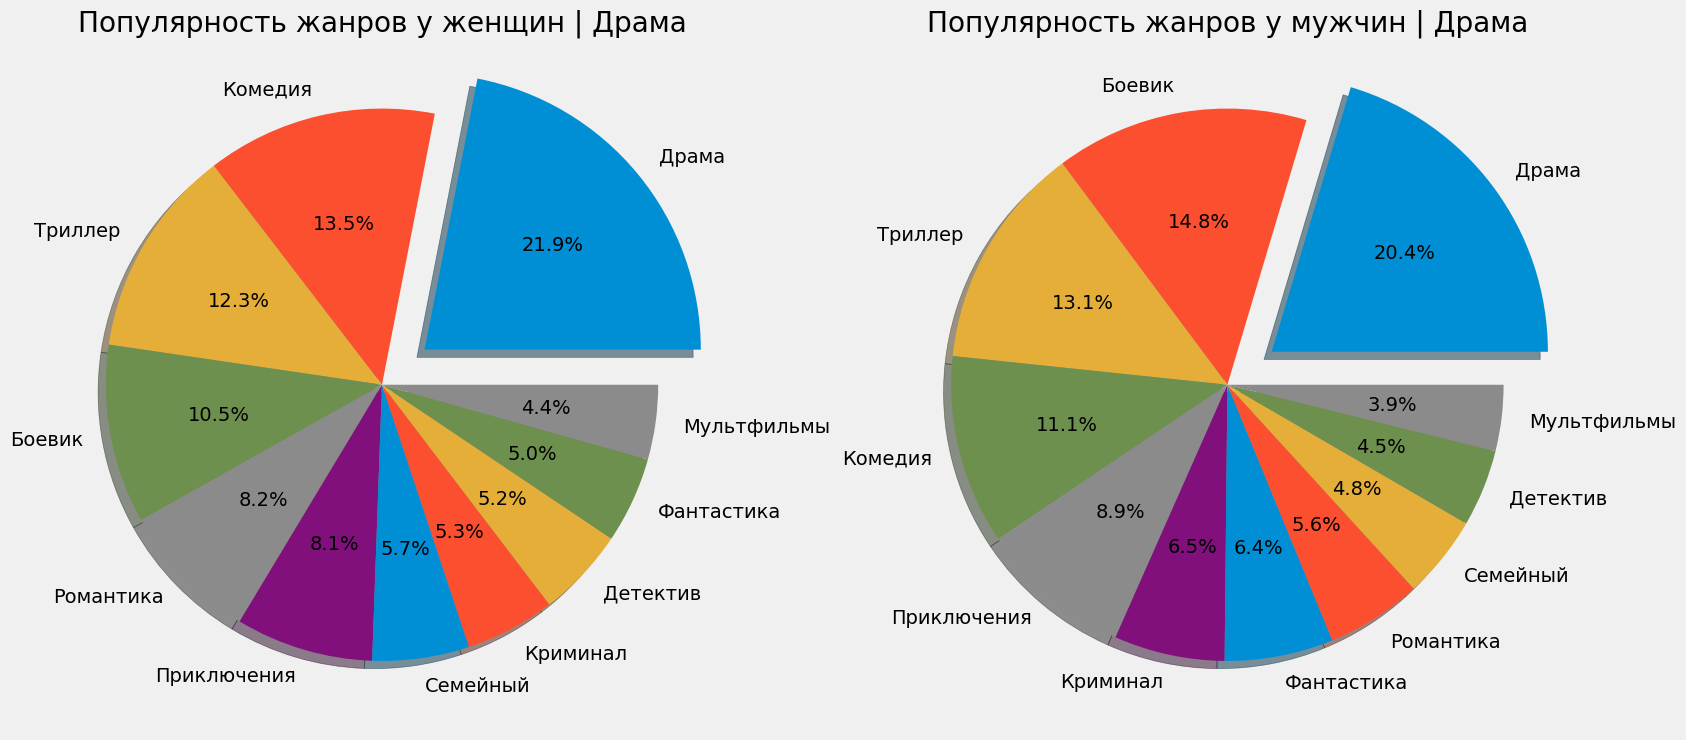

In [43]:
plt.figure(figsize=(17, 9))

SEX = {
    'М' : 'мужчин',
    'Ж' : 'женщин'
}

for i, sex in enumerate(['Ж', 'М']):
    GENRES = {}

    tmp_df = df.loc[df['sex'] == sex].copy()

    for genres_row, count in zip(tqdm(tmp_df['genres'].value_counts().index), tmp_df['genres'].value_counts()):
        genres = genres_row.split(',')
        for genre in genres:
            try:
                GENRES[genre]
            except KeyError:
                GENRES[genre] = 0
            GENRES[genre] += count
            
    genres_df = pd.DataFrame(GENRES, index=range(1)).T.reset_index()
    genres_df = genres_df.rename(columns={'index' : 'genre', 0 : 'count'}).sort_values(by='count', ascending=False).reset_index(drop=True)
    genres_df = genres_df.iloc[:11]
    
    plt.subplot(1, 2, i+1)
    plt.title(f"Популярность жанров у {SEX[sex]} | {genres_df['genre'][0]}")
    y = list(genres_df['count'])
    labels = list(genres_df['genre'])
    explode = [0.2] + [0 for _ in range(len(y) - 1)]
    plt.pie(y, labels = labels, explode = explode, shadow = True, autopct='%1.1f%%', startangle=0)
    plt.tight_layout()

### Monetary

In [27]:
df['income'].value_counts()

income_20_40      37367
income_40_60      20702
income_60_90       5500
income_0_20        1774
income_90_150      1096
income_150_inf       79
Name: income, dtype: int64

In [28]:
mon = df.loc[df['income'].isna() == False].reset_index(drop=True)


def get_monetary(x):
    if '150' in x:
        return 'M1'
    elif '20' in x:
        return 'M3'
    return 'M2'

mon['monetary'] = mon['income'].map(get_monetary)

In [29]:
mon = mon[['user_id', 'monetary', 'income']].drop_duplicates(subset=['user_id'])

<AxesSubplot: title={'center': 'Monetary'}, xlabel='Количество пользователей', ylabel='Уровень платёжеспособности'>

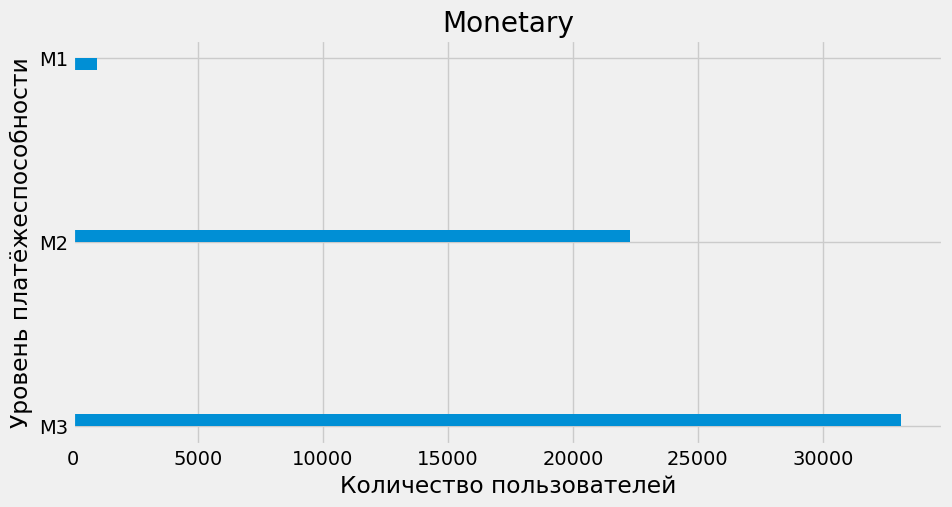

In [30]:
plt.figure(figsize=(10, 5))
plt.title('Monetary')
plt.xlabel('Количество пользователей')
plt.ylabel('Уровень платёжеспособности')
mon['monetary'].hist(bins=30, orientation='horizontal')

In [31]:
mon.groupby('monetary')['income'].agg(['count'])

,count
monetary,
M1,985
M2,22297
M3,33138


### Объединение всех

In [32]:
results = pd.merge(rec[['user_id', 'recency']], freq[['user_id', 'frequency']], on='user_id', how='inner')
results = pd.merge(results, mon[['user_id', 'monetary']], on='user_id', how='inner')
results['rfm_group'] = results['recency'] + results['frequency'] + results['monetary']
results

,user_id,recency,frequency,monetary,rfm_group
0,2,R2,F2,M2,R2F2M2
1,25,R2,F3,M3,R2F3M3
2,46,R2,F2,M3,R2F2M3
3,55,R3,F1,M2,R3F1M2
4,126,R1,F2,M3,R1F2M3
...,...,...,...,...,...
49670,1097435,R2,F2,M2,R2F2M2
49671,1097444,R1,F1,M3,R1F1M3
49672,1097459,R2,F2,M2,R2F2M2
49673,1097508,R3,F3,M2,R3F3M2


In [33]:
results['rfm_group'].value_counts()

R2F2M3    5909
R1F3M3    5003
R2F3M3    4877
R2F2M2    4022
R1F2M3    3605
R2F3M2    3163
R1F3M2    3030
R3F2M3    2860
R3F3M3    2844
R1F2M2    2355
R2F1M3    2291
R3F2M2    2225
R3F3M2    1916
R2F1M2    1684
R1F1M3    1312
R1F1M2     949
R3F1M3     433
R3F1M2     305
R2F2M1     200
R2F3M1     108
R3F2M1     106
R1F3M1     106
R2F1M1      97
R1F2M1      97
R3F3M1      91
R1F1M1      69
R3F1M1      18
Name: rfm_group, dtype: int64

In [34]:
results_description = results.copy()
results_description['recency'] = results_description['recency'].map({'R1' : 'недавние', 'R2' : 'спящие', 'R3' : 'давние'})
results_description['frequency'] = results_description['frequency'].map({'F1' : 'частые', 'F2' : 'редкие', 'F3' : 'очень редкие'})
results_description['monetary'] = results_description['monetary'].map({'M1' : 'с высокой платёжеспособностью', 'M2' : 'со средней платёжеспособностью', 'M3' : 'с низкой платёжеспособностью'})
results_description['mr'] = results_description['monetary'] + ' ' + results_description['recency']
results_description

,user_id,recency,frequency,monetary,rfm_group,mr
0,2,спящие,редкие,со средней платёжеспособностью,R2F2M2,со средней платёжеспособностью спящие
1,25,спящие,очень редкие,с низкой платёжеспособностью,R2F3M3,с низкой платёжеспособностью спящие
2,46,спящие,редкие,с низкой платёжеспособностью,R2F2M3,с низкой платёжеспособностью спящие
3,55,давние,частые,со средней платёжеспособностью,R3F1M2,со средней платёжеспособностью давние
4,126,недавние,редкие,с низкой платёжеспособностью,R1F2M3,с низкой платёжеспособностью недавние
...,...,...,...,...,...,...
49670,1097435,спящие,редкие,со средней платёжеспособностью,R2F2M2,со средней платёжеспособностью спящие
49671,1097444,недавние,частые,с низкой платёжеспособностью,R1F1M3,с низкой платёжеспособностью недавние
49672,1097459,спящие,редкие,со средней платёжеспособностью,R2F2M2,со средней платёжеспособностью спящие
49673,1097508,давние,очень редкие,со средней платёжеспособностью,R3F3M2,со средней платёжеспособностью давние


In [35]:
rfm = results_description.groupby(['mr', 'frequency'], as_index=False)['user_id'].count()
rfm

,mr,frequency,user_id
0,с высокой платёжеспособностью давние,очень редкие,91
1,с высокой платёжеспособностью давние,редкие,106
2,с высокой платёжеспособностью давние,частые,18
3,с высокой платёжеспособностью недавние,очень редкие,106
4,с высокой платёжеспособностью недавние,редкие,97
5,с высокой платёжеспособностью недавние,частые,69
6,с высокой платёжеспособностью спящие,очень редкие,108
7,с высокой платёжеспособностью спящие,редкие,200
8,с высокой платёжеспособностью спящие,частые,97
9,с низкой платёжеспособностью давние,очень редкие,2844


In [36]:
rfm_pivot = rfm.pivot(index='mr', columns='frequency', values='user_id').reset_index()
rfm_pivot.fillna(0, inplace=True)
rfm_pivot = rfm_pivot.set_index('mr')
rfm_pivot

frequency,очень редкие,редкие,частые
mr,,,
с высокой платёжеспособностью давние,91,106,18
с высокой платёжеспособностью недавние,106,97,69
с высокой платёжеспособностью спящие,108,200,97
с низкой платёжеспособностью давние,2844,2860,433
с низкой платёжеспособностью недавние,5003,3605,1312
с низкой платёжеспособностью спящие,4877,5909,2291
со средней платёжеспособностью давние,1916,2225,305
со средней платёжеспособностью недавние,3030,2355,949
со средней платёжеспособностью спящие,3163,4022,1684


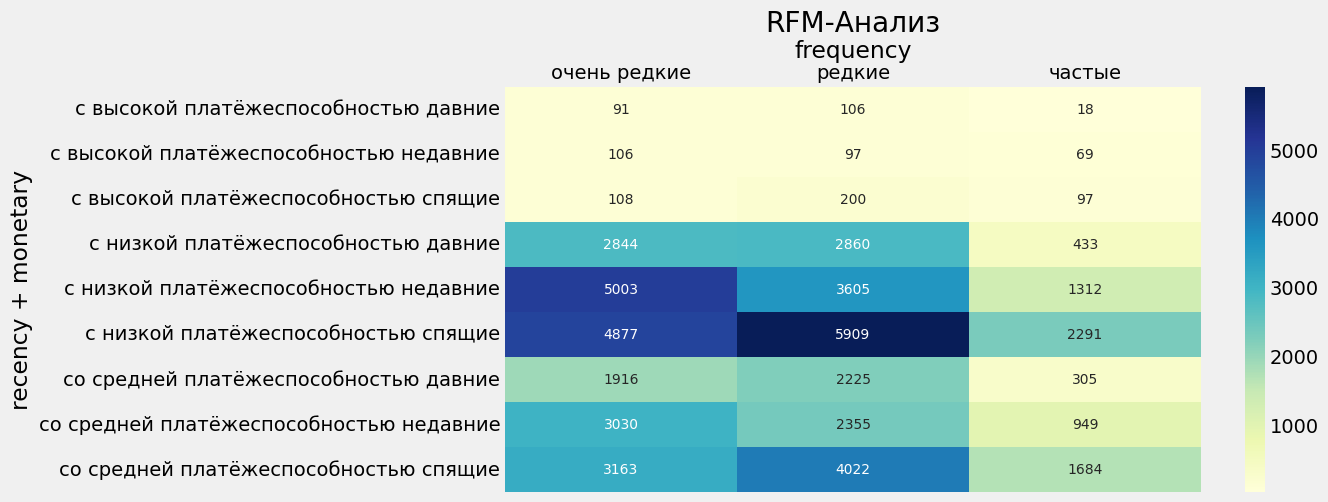

In [37]:
f, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(
    rfm_pivot,
    annot=True,
    cmap='YlGnBu',
    fmt='g',
    annot_kws={'size' : 10}
)

plt.title('RFM-Анализ')

plt.yticks(rotation=0)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.ylabel('recency + monetary')
plt.xlabel('frequency')

plt.show()